In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Signac))
suppressMessages(library(GenomicRanges))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))

source('reproducibility_helper.R')

In [2]:
output_dir <- '/projects/chang/scGRN/analysis/real_data/output'
fig_dir <- '/projects/chang/scGRN/analysis/manuscript/figures'

In [3]:
cts_CG <- c('Microglia', 'Excitatory', 'Inhibitory', 'Oligodendrocytes', 'Astrocytes')
ct_list <- lapply(cts_CG, function(ct) c(ct, substr(ct, 1, 3)))

datasets <- c('brain_CG', 'brain_ROSMAP')

res_list <- list()


fn_suffix <- c('_batch_adjusted', '_permu_adjusted', '_batch_as_covar_adjusted_n_bootstrap_5000')
methods <- c('proposed', 'Signac', 'SCENT')
names(fn_suffix) <- methods

In [4]:
p_cutoffs <- c(0.05,0.1,0.2)

ct_sum_list <- list()
for(i_ct in 1:5){
    res_list <- list()
    res_list[['proposed']] <- load_proposed(ct_list[[i_ct]], datasets = datasets,
                                       fn_suffix = fn_suffix['proposed']) 
    res_list[['Signac']] <- load_Signac(ct_list[[i_ct]], datasets = datasets,
                                       fn_suffix = fn_suffix['Signac']) 
    res_list[['SCENT']] <- load_SCENT(ct_list[[i_ct]], 
                                  n_sets = ifelse(cts_CG[i_ct] %in% c('Microglia', 'Astrocytes'), 10, 20),
                                  # c(ifelse(i_ct==4,200,50),10), 
                                  datasets = datasets,
                                  fn_suffix = fn_suffix['SCENT']) 

    sum_list <- list()
    for(nc in 1:length(p_cutoffs)){
        comb_list <- list(c(1,2))
        methods <- names(res_list)
        pval_vec <- fc_vec <- power_d1 <- power_d2 <- overlap_counts <- sig_counts_1 <- sig_counts_2 <- n_overlap <- numeric()
        fe_pval_vec <- fe_fc_vec <- fe_conf_l_vec <- fe_conf_u_vec <- numeric()
        results_list <- list()
        t <- 1
        for(i in 1:length(comb_list)){
            for(method in methods){
                tmp <- get_overlap(res_list[[method]][comb_list[[i]]],
                                   #n_cutoff=n_cutoffs[nc]
                                   #p_var='pval', p_cutoff=0.05
                                   #n_cutoff = 5000
                               p_var = 'adj_pval', p_cutoff = p_cutoffs[nc]
                                      )
                pval_vec <- c(pval_vec, tmp$log_p_val)
                fc_vec <- c(fc_vec, tmp$fc)
                power_d1 <- c(power_d1, tmp$counts[[2]][1]/tmp$counts[[3]])
                power_d2 <- c(power_d2, tmp$counts[[2]][2]/tmp$counts[[3]])
                overlap_counts <- c(overlap_counts, tmp$counts[[1]])
                results_list[[t]] <- tmp

                # fisher exact test
                n_overlap_pairs <- results_list[[t]]$counts[[3]]
                n_sig_one_dataset <- results_list[[t]]$counts[[2]]
                n_sig_both <- results_list[[t]]$counts[[1]]

                D <- n_sig_both
                B <- n_sig_one_dataset[1] - D
                C <- n_sig_one_dataset[2] - D
                A <- n_overlap_pairs - (B + C + D)

                tab <- matrix(c(A,B,C,D), nrow = 2)
                fe_res <- fisher.test(tab, alternative = 'greater')

                fe_pval_vec <- c(fe_pval_vec, fe_res$p.value)
                fe_fc_vec <- c(fe_fc_vec, fe_res$estimate)
                fe_conf_l_vec <- c(fe_conf_l_vec, fe_res$conf.int[1])
                fe_conf_u_vec <- c(fe_conf_u_vec, fe_res$conf.int[2])

                sig_counts_1 <- c(sig_counts_1, n_sig_one_dataset[1])
                sig_counts_2 <- c(sig_counts_2, n_sig_one_dataset[2])
                n_overlap <- c(n_overlap, n_overlap_pairs)
                
                t <- t + 1
            }
        }
        sum_list[[nc]] <- data.frame(pval = -pval_vec, fc = fc_vec, power1 = power_d1, power2 = power_d2, repro_counts = overlap_counts,
                                    fe_pval = fe_pval_vec, fe_or = fe_fc_vec, fe_conf_l = fe_conf_l_vec, fe_conf_u = fe_conf_u_vec,
                                    sig_counts_1 = sig_counts_1, sig_counts_2 = sig_counts_2, n_overlap = n_overlap)
    }
    sum_df <- do.call(rbind, sum_list)
    sum_df$method <- rep(methods, 3)
    sum_df$p_cutoff <- rep(p_cutoffs, each = 3)
    sum_df$method <- factor(sum_df$method, levels = methods, labels = methods)
    ct_sum_list[[cts_CG[i_ct]]] <- sum_df
}

In [5]:
long_ct_sum_df <- do.call(rbind, ct_sum_list)
long_ct_sum_df$cell_type = rep(cts_CG, each = nrow(ct_sum_list[[1]]))
long_ct_sum_df$cell_type <- factor(long_ct_sum_df$cell_type,
                                   levels = cts_CG,
                                   labels = c('Microglia', 'Excitatory neurons', 'Inhibitory neurons', 'Oligodendrocytes', 'Astrocytes'))
long_ct_sum_df$method <- factor(long_ct_sum_df$method,
                                levels = c('proposed', 'Signac', 'SCENT'),
                                labels = c('scMultiMap', 'Signac', 'SCENT'))

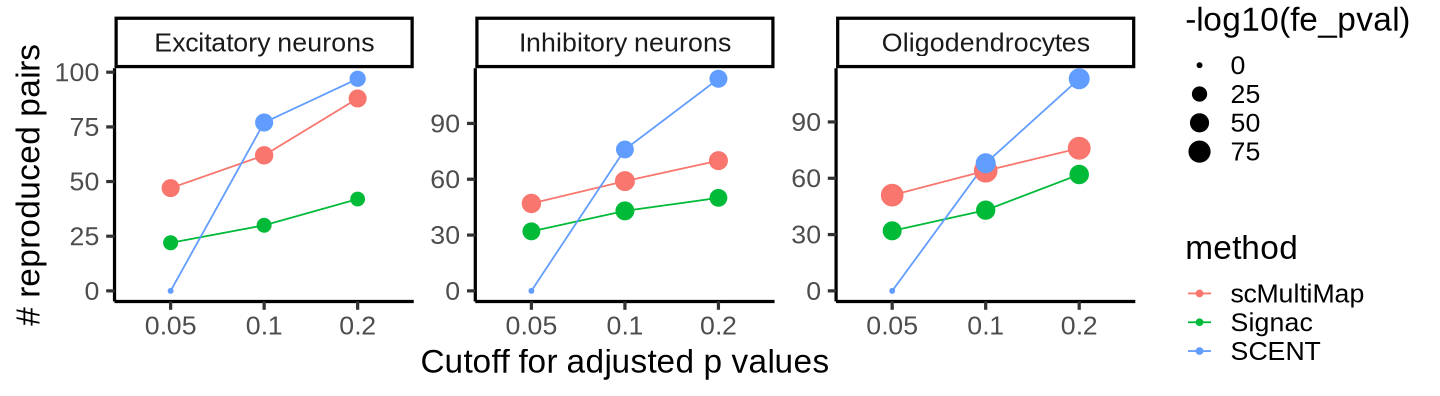

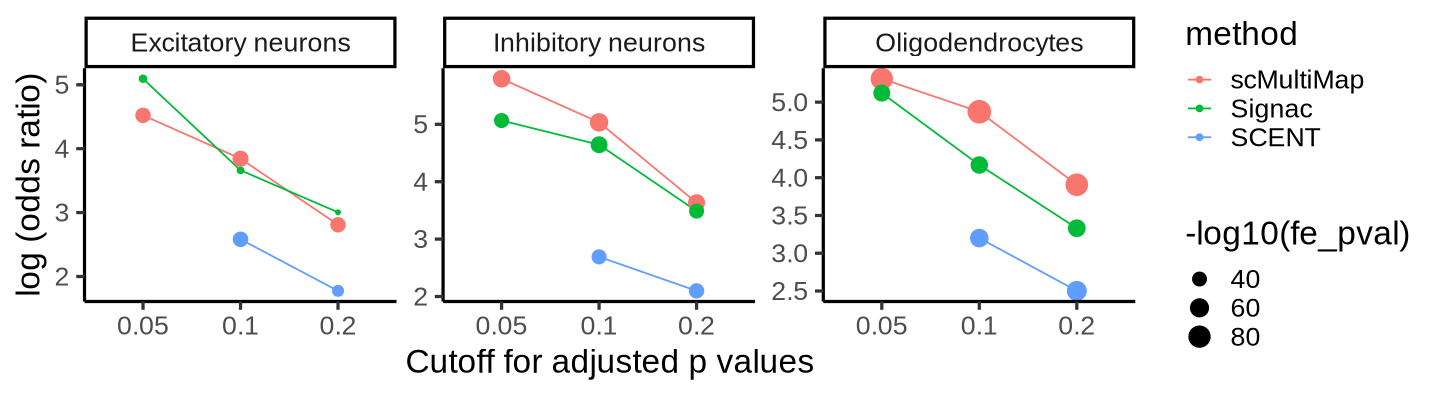

In [6]:
options(repr.plot.width = 4*3, repr.plot.height = 3.3)

# 1. Focus on three abundant cell types
# 2. Remove record with 0 overlap counts
# 3. Use -log10(pvalue) from fisher exact test with alternative='greater'
# 4. Use log odds ratio from fisher exact test with alternative='greater'


ggplot(long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia'),],
       aes(x = as.factor(p_cutoff), y = repro_counts, group = method, color = method)) +
        geom_line() +
        geom_point(aes(size = -log10(fe_pval))) +
        labs(y = '# reproduced pairs', x = 'Cutoff for adjusted p values') +
facet_wrap(~cell_type , scales = 'free') +
        #geom_errorbar( aes(ymin = log(fe_conf_l), ymax = log(fe_conf_u)),width = 20, alpha = 0.6) +
        theme_classic(base_size = 20 )

ggplot(long_ct_sum_df[!long_ct_sum_df$cell_type %in% c('Astrocytes', 'Microglia') & long_ct_sum_df$repro_counts != 0,],
       aes(x = as.factor(p_cutoff), y = log(fe_or), group = method, color = method)) +
        geom_line() +
        geom_point(aes(size = -log10(fe_pval))) +
        labs(y = 'log (odds ratio)', x = 'Cutoff for adjusted p values') +
facet_wrap(~cell_type , scales = 'free') +
        #geom_errorbar( aes(ymin = log(fe_conf_l), ymax = log(fe_conf_u)),width = 20, alpha = 0.6) +
        theme_classic(base_size = 20 )

In [7]:
#saveRDS(long_ct_sum_df, 'output/manuscript/brain/reproducibility.rds')

# Supplementary analysis for GBM

In [8]:
qu_cutoffs <- c(0.85,0.9,0.95)

ct_sum_list <- list()
for(i_ct in 2:4){
    sum_list <- list()
    #for(nc in 1:length(p_cutoffs)){
        for(nc in 1:length(qu_cutoffs)){
        comb_list <- list(c(1,2))
        methods <- names(res_list)
        pval_vec <- fc_vec <- power_d1 <- power_d2 <- overlap_counts <- sig_counts_1 <- sig_counts_2 <- n_overlap <- numeric()
        fe_pval_vec <- fe_fc_vec <- fe_conf_l_vec <- fe_conf_u_vec <- numeric()
        results_list <- list()
        t <- 1
        for(i in 1:length(comb_list)){
            GBM_res <- load_GBM(ct_list[[i_ct]], datasets = datasets[comb_list[[i]]], method_par = qu_cutoffs[nc])
            #for(method in methods){
                tmp <- get_overlap(GBM_res,
                                   #n_cutoff=n_cutoffs[nc]
                                   p_var='pval', p_cutoff=0.05
                                   #n_cutoff = 5000
                               #p_var = 'adj_pval', p_cutoff = p_cutoffs[nc]
                                      )
                pval_vec <- c(pval_vec, tmp$log_p_val)
                fc_vec <- c(fc_vec, tmp$fc)
                power_d1 <- c(power_d1, tmp$counts[[2]][1]/tmp$counts[[3]])
                power_d2 <- c(power_d2, tmp$counts[[2]][2]/tmp$counts[[3]])
                overlap_counts <- c(overlap_counts, tmp$counts[[1]])
                results_list[[t]] <- tmp

                # fisher exact test
                n_overlap_pairs <- results_list[[t]]$counts[[3]]
                n_sig_one_dataset <- results_list[[t]]$counts[[2]]
                n_sig_both <- results_list[[t]]$counts[[1]]

                D <- n_sig_both
                B <- n_sig_one_dataset[1] - D
                C <- n_sig_one_dataset[2] - D
                A <- n_overlap_pairs - (B + C + D)

                tab <- matrix(c(A,B,C,D), nrow = 2)
                fe_res <- fisher.test(tab, alternative = 'greater')

                fe_pval_vec <- c(fe_pval_vec, fe_res$p.value)
                fe_fc_vec <- c(fe_fc_vec, fe_res$estimate)
                fe_conf_l_vec <- c(fe_conf_l_vec, fe_res$conf.int[1])
                fe_conf_u_vec <- c(fe_conf_u_vec, fe_res$conf.int[2])

                sig_counts_1 <- c(sig_counts_1, n_sig_one_dataset[1])
                sig_counts_2 <- c(sig_counts_2, n_sig_one_dataset[2])
                n_overlap <- c(n_overlap, n_overlap_pairs)
                
                t <- t + 1
            #}
        }
        sum_list[[nc]] <- data.frame(pval = -pval_vec, fc = fc_vec, power1 = power_d1, power2 = power_d2, repro_counts = overlap_counts,
                                    fe_pval = fe_pval_vec, fe_or = fe_fc_vec, fe_conf_l = fe_conf_l_vec, fe_conf_u = fe_conf_u_vec,
                                    sig_counts_1 = sig_counts_1, sig_counts_2 = sig_counts_2, n_overlap = n_overlap)
    }
    sum_df <- do.call(rbind, sum_list)
    sum_df$method <- 'GBM'#rep(methods, 3)
    sum_df$qu_cutoff <- qu_cutoffs
    #sum_df$method <- factor(sum_df$method, levels = methods, labels = methods)
    ct_sum_list[[cts_CG[i_ct]]] <- sum_df
}

sum_df_GBM <- do.call(rbind, ct_sum_list)
sum_df_GBM$cell_type <- rep(cts_CG[2:4], each = 3)

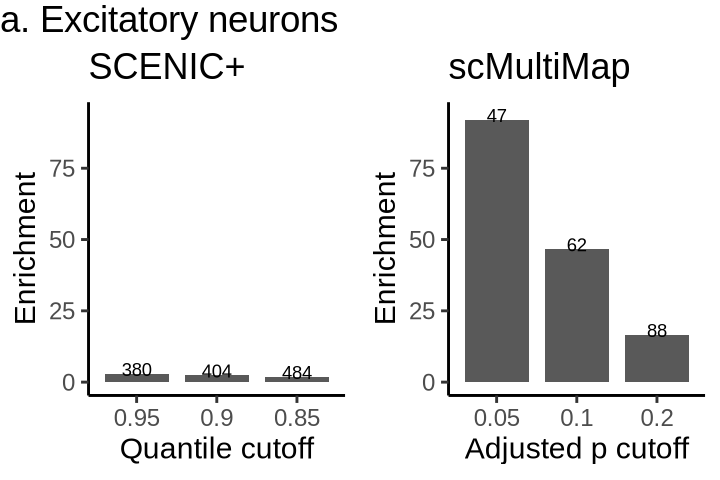

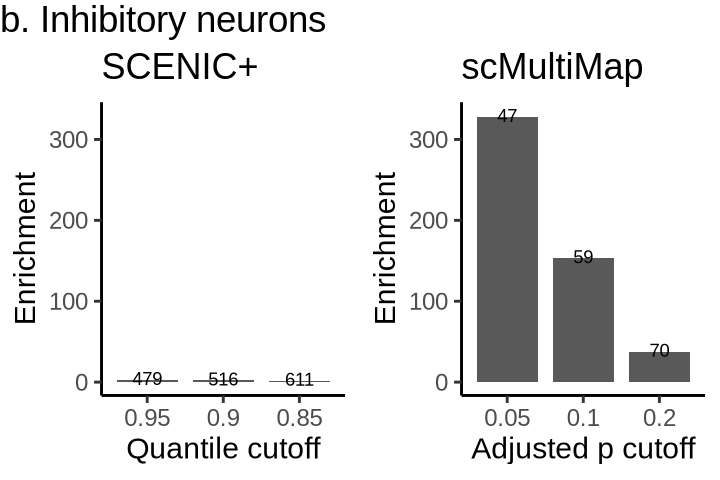

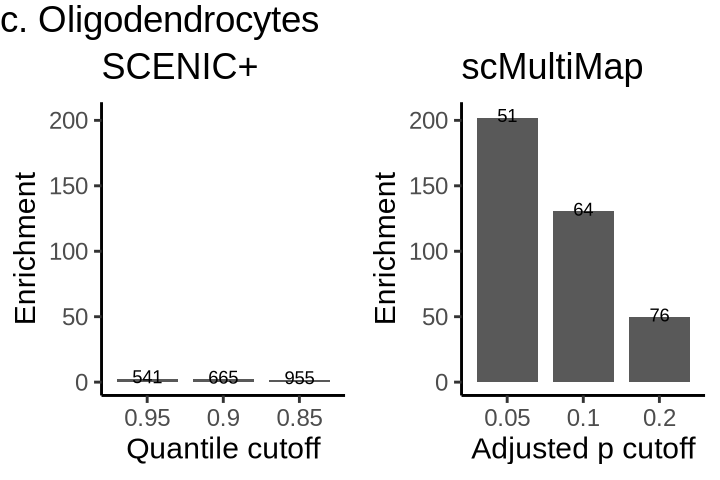

In [16]:
fig_letter <- c('a','b','c')
names(fig_letter) <- cts_CG[2:4]
for(ct in cts_CG[c(2:4)]){
    g_list <- list()
    proposed_df <- long_ct_sum_df[grepl(ct, long_ct_sum_df$cell_type) &
                                  long_ct_sum_df$method == 'scMultiMap', c('fe_or', 'pval','p_cutoff', 'method', 'repro_counts')]
    
    g_list[[2]] <- ggplot(proposed_df, 
                          aes( x = factor(p_cutoff), y = fe_or)) +
    geom_bar(stat = 'identity', width = 0.8) +
    geom_text(aes(label = repro_counts), nudge_y = 1.5) +
    ylim(c(0, max(proposed_df$fe_or)+1.5)) +
    labs(x = 'Adjusted p cutoff', y = 'Enrichment', title = 'scMultiMap') + 
    theme_classic(base_size = 18) 

    tmp <- sum_df_GBM[sum_df_GBM$cell_type == ct, c('fe_or', 'pval','qu_cutoff', 'repro_counts')]
    g_list[[1]] <- ggplot(tmp, 
                      aes(x = factor(qu_cutoff, levels = c(0.95,0.9,0.85), labels = c(0.95,0.9,0.85)), y = fe_or)) +
    geom_bar(stat = 'identity', width = 0.8) +
    geom_text(aes(label = repro_counts), nudge_y = 1.5) +
    ylim(c(0, max(proposed_df$fe_or)+1.5)) +
    labs(x = 'Quantile cutoff', y = 'Enrichment', title = 'SCENIC+') + 
    theme_classic(base_size = 18) 



    options(repr.plot.width = 6, repr.plot.height = 4)
    g <- grid.arrange(grobs = g_list, nrow = 1, top = 
             textGrob(paste(fig_letter[ct],
                            ifelse(ct == 'Oligodendrocytes', ct,
                            sprintf('%s neurons', ct)), sep = '. '), 
                      gp=gpar(fontsize=22), x = 0, hjust = 0))
    ggsave(sprintf('%s/brain/reproducibility_GBM_%s.pdf', fig_dir, ct), g, width = 6, height = 4)
}